# Data Dictionary

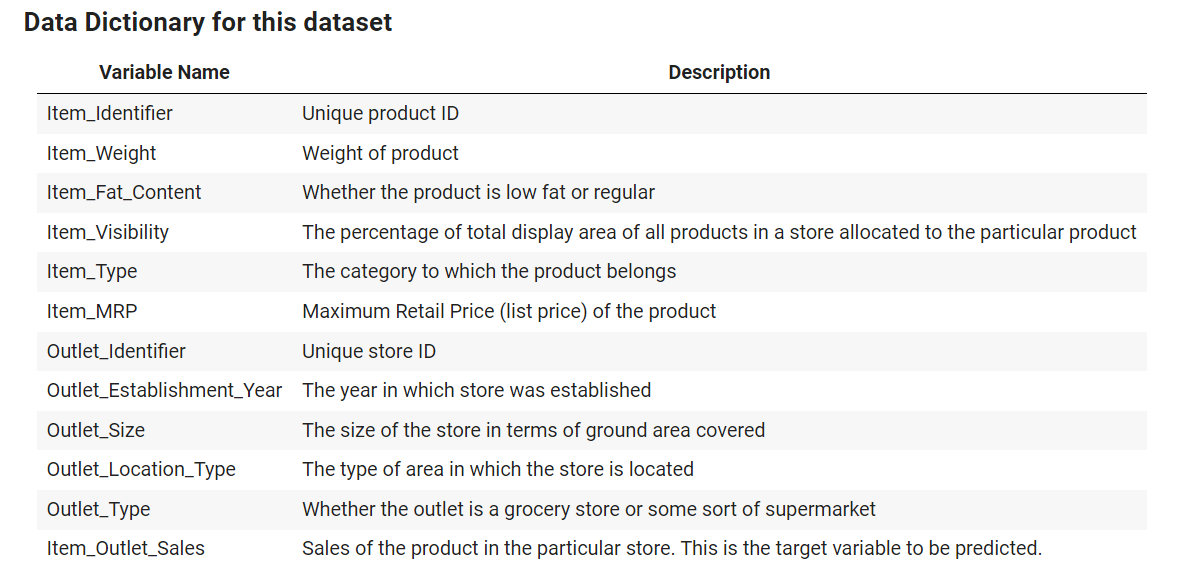

# Load Data

In [1]:
# standard
import pandas as pd
import numpy as np

# preprocess
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# display
from sklearn import set_config
set_config(display='diagram')
pd.set_option('display.max_columns', 50)

# model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# evaluate
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# visualize
import matplotlib.pyplot as plt
import seaborn as sns

# serialize
import joblib

# Data Cleaning

In [2]:
# load data
df = pd.read_csv('sales_predictions.csv')

# check
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

# Helper Functions

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test):
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    """Source: Coding Dojo Learn Platform"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)

    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)

    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [4]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    """Gets coefficients and intercept from the fit linear regression"""
    """Source: Coding Dojo Learn Platform"""
    
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
        
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [5]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Source: Coding Dojo Learn Platform"""
    
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [6]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax


In [7]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    """Gets importances from a tree-based model
    Source: Coding Dojo Learn Platform"""

    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)

    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

In [8]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    """Plots given importances
    Source: Coding Dojo Learn Platform"""
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [9]:
# check for and drop duplicates if present
df.duplicated().sum()

0

In [10]:
# check for and fix inconsistencies (like spelling)
for column in df.select_dtypes(include = 'object'):
  print(f"{column} value counts: \n{df[column].value_counts()}\n")

Item_Identifier value counts: 
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

Item_Fat_Content value counts: 
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Item_Type value counts: 
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Outlet_Identifier value counts: 
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    9

In [11]:
# fix Item_Fat_Content inconsistencies
df.replace({'LF': 'Low Fat', 
            'reg': 'Regular', 
            'low fat': 'Low Fat'},
           inplace = True)

# check
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [12]:
# drop unnecessary column 'Item_Identifier' (high-cardinality feature)
df.drop(columns = 'Item_Identifier', inplace = True)

# check
df.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

In [13]:
# check column dtypes
df.dtypes

Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

# Preprocessing

In [14]:
# split data into X and y
target = 'Item_Outlet_Sales'
y = df[target].copy()
X = df.drop(columns = [target]).copy()

# check
print(y.shape)
print(X.shape)

(8523,)
(8523, 10)


In [15]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [16]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
# create categorical column selector
cat_sel = make_column_selector(dtype_include = 'object')

# check
cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [17]:
# create numeric column selector
num_sel = make_column_selector(dtype_include = 'number')

# check
num_sel(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [18]:
# inspect values of categorical columns to select values to drop
# to reduce multicollinearity
for col in cat_sel(X):
    print(f"For {col}:\n{X[col].unique()}\n")

For Item_Fat_Content:
['Low Fat' 'Regular']

For Item_Type:
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

For Outlet_Identifier:
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

For Outlet_Size:
['Medium' nan 'High' 'Small']

For Outlet_Location_Type:
['Tier 1' 'Tier 3' 'Tier 2']

For Outlet_Type:
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [19]:
# select values to drop for each cat column
drop_cats = ['Regular', 'Others', 'OUT010', 'High', 'Tier 3',
            'Grocery Store']

In [20]:
# create pipelines and preprocessor
cat_pipe = make_pipeline(SimpleImputer(strategy = 'constant',
                                      fill_value = 'MISSING'),
                        OneHotEncoder(drop = drop_cats, # to reduce multicollinearity
                                     sparse = False))

num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'))

preprocessor = make_column_transformer((num_pipe, num_sel),
                                      (cat_pipe, cat_sel),
                                      verbose_feature_names_out = False)

# check
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000219C3871CD0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop=['Regular',
                                                                      'Others',
                                                                      'OUT010',
                                                                      'High',
                                                                      'Tier 3',
                                                                      'Grocery '
                                                                      'Store'],
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000219BD61DFA0>)],
                  verbose_feature_names_out=False)

In [21]:
# fit preprocessor
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000219C3871CD0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop=['Regular',
                                                                      'Others',
                                                                      'OUT010',
                                                                      'High',
                                                                      'Tier 3',
                                                                      'Grocery '
                                                                      'Store'],
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000219BD61DFA0>)],
                  verbose_feature_names_out=False)

In [22]:
# run get_feature_names_out
feature_names = preprocessor.get_feature_names_out()

# check
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_Low Fat',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Size_MISSING', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Type_Supermarket Type1', 'Outlet

In [23]:
# create transformed df for training data
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns = feature_names,
                         index = X_train.index)

# check
X_train_df.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
4776       16.350         0.029565  256.4646                     2009.0   
7510       15.250         0.000000  179.7660                     2009.0   
5828       12.350         0.158716  157.2946                     1999.0   
5327        7.975         0.014628   82.3250                     2004.0   
4810       19.350         0.016645  120.9098                     2002.0   

      Item_Fat_Content_Low Fat  Item_Type_Baking Goods  Item_Type_Breads  \
4776                       1.0                     0.0               0.0   
7510                       0.0                     0.0               0.0   
5828                       0.0                     0.0               0.0   
5327                       1.0                     1.0               0.0   
4810                       1.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
4776                  0.0               0.0              0.0   
7510                  0.0               0.0              0.0   
5828                  0.0               0.0              0.0   
5327                  0.0               0.0              0.0   
4810                  0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
4776                     0.0                              0.0   
7510                     0.0                              0.0   
5828                     0.0                              0.0   
5327                     0.0                              0.0   
4810                     1.0                              0.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
4776                    0.0                           0.0   
7510                    0.0                           0.0   
5828                    0.0                           0.0   
5327                    0.0                           0.0   
4810                    0.0                           0.0   

      Item_Type_Household  Item_Type_Meat  Item_Type_Seafood  \
4776                  1.0             0.0                0.0   
7510                  0.0             0.0                0.0   
5828                  0.0             1.0                0.0   
5327                  0.0             0.0                0.0   
4810                  0.0             0.0                0.0   

      Item_Type_Snack Foods  Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
4776                    0.0                    0.0                      0.0   
7510                    1.0                    0.0                      0.0   
5828                    0.0                    0.0                      0.0   
5327                    0.0                    0.0                      0.0   
4810                    0.0                    0.0                      0.0   

      Outlet_Identifier_OUT013  Outlet_Identifier_OUT017  \
4776                       0.0                       0.0   
7510                       0.0                       0.0   
5828                       0.0                       0.0   
5327                       0.0                       0.0   
4810                       0.0                       0.0   

      Outlet_Identifier_OUT018  Outlet_Identifier_OUT019  \
4776                       1.0                       0.0   
7510                       1.0                       0.0   
5828                       0.0                       0.0   
5327                       0.0                       0.0   
4810                       0.0                       0.0   

      Outlet_Identifier_OUT027  Outlet_Identifier_OUT035  \
4776                       0.0                       0.0   
7510                       0.0                       0.0   
5828                       0.0                       0.0   
5327                       0.0                       1.0   
4810                       0.0                       0.0   

      Outlet

In [24]:
# create transformed df for testing data
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         columns = feature_names,
                         index = X_test.index)

# check
X_test_df.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
7503    14.300000         0.026300   79.4302                     1987.0   
2957     7.930000         0.071136   42.7086                     1997.0   
7031    14.500000         0.041313   42.0454                     1999.0   
1084    12.904458         0.044767  173.7054                     1985.0   
856     10.195000         0.012456  197.5110                     2004.0   

      Item_Fat_Content_Low Fat  Item_Type_Baking Goods  Item_Type_Breads  \
7503                       1.0                     0.0               0.0   
2957                       1.0                     0.0               0.0   
7031                       0.0                     0.0               0.0   
1084                       0.0                     0.0               0.0   
856                        0.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
7503                  0.0               0.0              0.0   
2957                  0.0               0.0              0.0   
7031                  0.0               1.0              0.0   
1084                  0.0               0.0              0.0   
856                   0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
7503                     1.0                              0.0   
2957                     0.0                              0.0   
7031                     0.0                              0.0   
1084                     0.0                              0.0   
856                      0.0                              0.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
7503                    0.0                           0.0   
2957                    0.0                           1.0   
7031                    0.0                           0.0   
1084                    0.0                           0.0   
856                     0.0                           0.0   

      Item_Type_Household  Item_Type_Meat  Item_Type_Seafood  \
7503                  0.0             0.0                0.0   
2957                  0.0             0.0                0.0   
7031                  0.0             0.0                0.0   
1084                  0.0             0.0                0.0   
856                   0.0             1.0                0.0   

      Item_Type_Snack Foods  Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
7503                    0.0                    0.0                      0.0   
2957                    0.0                    0.0                      0.0   
7031                    0.0                    0.0                      0.0   
1084                    0.0                    1.0                      0.0   
856                     0.0                    0.0                      0.0   

      Outlet_Identifier_OUT013  Outlet_Identifier_OUT017  \
7503                       1.0                       0.0   
2957                       0.0                       0.0   
7031                       0.0                       0.0   
1084                       0.0                       0.0   
856                        0.0                       0.0   

      Outlet_Identifier_OUT018  Outlet_Identifier_OUT019  \
7503                       0.0                       0.0   
2957                       0.0                       0.0   
7031                       0.0                       0.0   
1084                       0.0                       0.0   
856                        0.0                       0.0   

      Outlet_Identifier_OUT027  Outlet_Identifier_OUT035  \
7503                       0.0                       0.0   
2957                       0.0                       0.0   
7031                       0.0                       0.0   
1084                       1.0                       0.0   
856                        0.0                       1.0   

      Outlet

In [25]:
# confirm y_test index matches X_test_df index
y_test.head()

7503    1743.0644
2957     356.8688
7031     377.5086
1084    5778.4782
856     2356.9320
Name: Item_Outlet_Sales, dtype: float64

# Linear Regression

### Fit and Evaluate

In [26]:
# instantiate
lin_reg = LinearRegression()

# fit
lin_reg.fit(X_train_df, y_train)

# evaluate
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1139.10
Test Data:	R^2= 0.57	RMSE= 1092.86


### Extract Coefficients

In [27]:
# get coefficients
coefs = get_coeffs_linreg(lin_reg)

# check
coefs

Outlet_Size_MISSING                 -740.773753
Outlet_Identifier_OUT019            -510.785423
Item_Visibility                     -423.390180
Outlet_Location_Type_Tier 1         -239.627666
Outlet_Identifier_OUT049            -238.396546
Outlet_Size_Small                   -124.887878
Outlet_Identifier_OUT035            -123.656758
Item_Type_Dairy                      -79.521289
Item_Fat_Content_Low Fat             -62.625234
Outlet_Establishment_Year            -12.740586
Item_Type_Soft Drinks                -12.672009
Item_Weight                           -1.941817
Item_Type_Breads                      -1.834592
Item_Type_Snack Foods                  4.881333
Item_Type_Meat                        14.948839
Item_MRP                              15.720924
Item_Type_Frozen Foods                25.043100
Item_Type_Baking Goods                26.813726
Item_Type_Household                   32.323472
Item_Type_Hard Drinks                 40.708625
Item_Type_Health and Hygiene          53

### Visualize Top3 Coefficients

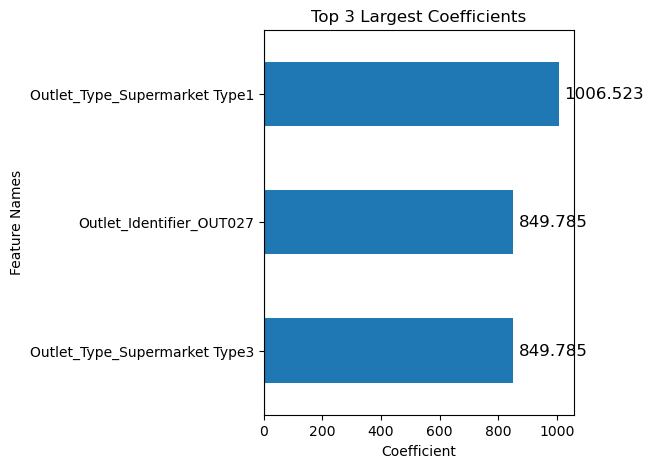

In [28]:
# plot coefficients
ax = plot_coeffs(coefs, 
                 top_n = 3, 
                 intercept = False,
                 annotate = True);

In [29]:
# save visualization
fig = ax.get_figure()
fig.savefig('images/linear_regression_top_3_coefficients.png',
           bbox_inches = 'tight' # figure will not be cropped
           )

## Interpret

The three largest coefficients plotted above are all one-hot encoded categorical features. This means their coefficients can be interpreted as how much the target changes if the observation belongs to that category. For the three categories above (largest to smallest):

If the observation belongs to 'Outlet_Type_Supermarket Type 1', then the target sales will increase by 1006.523 rupees.

If the observation belongs to 'Outlet_Type_Supermarket Type 2', then the target sales will increase by 849.785 rupees.

If the observation belongs to 'Outlet_Identifier_OUT027', then the target sales will increase by 849.785 rupees.

Note: The fact that the categories 'Outlet_Type_Supermarket Type 2' and 'Outlet_Identifier_OUT027' have the exact same coefficients tells me that there is probably collinearity between those categories and the data should be iterated on to remove that collinearity. For now, I will leave it as-is.


# Random Forest

### Fit and Evaluate

In [30]:
# instantiate
rf = RandomForestRegressor(max_depth = 5,
                          n_estimators = 141,
                          random_state = 42)

# fit
rf.fit(X_train_df, y_train)

# evaluate
evaluate_regression(rf, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.62	RMSE= 1060.92
Test Data:	R^2= 0.60	RMSE= 1045.92


### Extract Feature Importance

In [31]:
# get importances
importances = get_importances(rf, 
                              sort = True,
                              ascending = False,
                              name = 'RandomForest Importances')

# check
importances

Item_MRP                           0.546652
Outlet_Type_Supermarket Type1      0.150364
Outlet_Identifier_OUT027           0.094406
Outlet_Type_Supermarket Type3      0.085002
Outlet_Establishment_Year          0.038683
Outlet_Identifier_OUT018           0.024939
Outlet_Type_Supermarket Type2      0.023090
Outlet_Size_Medium                 0.021471
Item_Visibility                    0.007617
Outlet_Identifier_OUT019           0.003118
Item_Type_Starchy Foods            0.000526
Item_Type_Fruits and Vegetables    0.000510
Item_Type_Soft Drinks              0.000463
Item_Type_Breakfast                0.000366
Item_Type_Hard Drinks              0.000359
Item_Weight                        0.000346
Item_Type_Household                0.000290
Item_Type_Dairy                    0.000277
Item_Fat_Content_Low Fat           0.000221
Item_Type_Meat                     0.000219
Item_Type_Snack Foods              0.000207
Item_Type_Health and Hygiene       0.000178
Item_Type_Canned                

### Visualize Top 5 Feature Importances

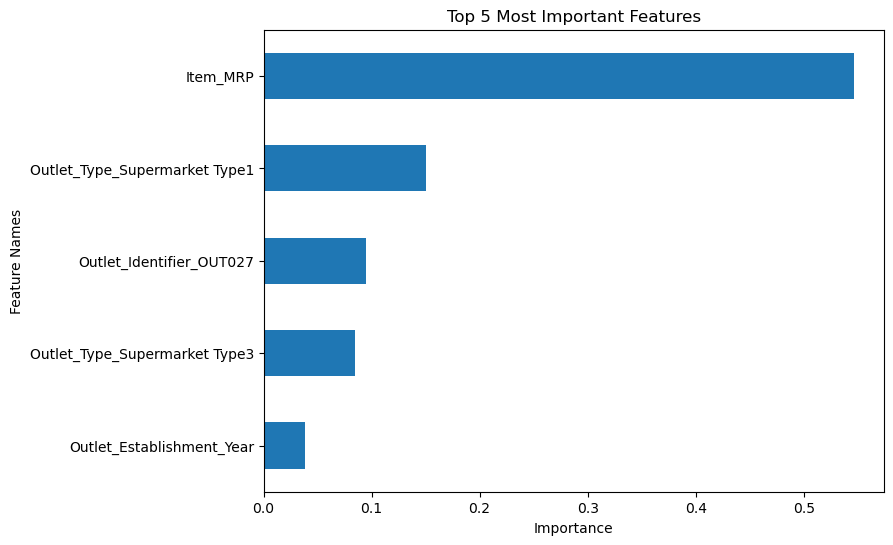

In [32]:
# plot top 5 importances
ax = plot_importance(importances, top_n = 5);

In [33]:
# save visualization
fig = ax.get_figure()
fig.savefig('Images/random_forest_regression_top_5_feature_importances.png',
           bbox_inches = 'tight' # figure will not be cropped
           )

## Interpret

For an interpretation, we keep in mind that built-in feature importances are biased toward valuing features with high-cardinality (like 'Item_MRP') over others. We also don't know the relationship of the feature to the target unless we do more EDA or employ additional tools.

With those caveats aside, we can see that the most important feature for our random forest regressor model is 'Item_MRP', with a feature importance of about 0.5. Because feature importances add up to 1, this means that the model heavily relied on 'Item_MRP' to make its decisions to split nodes (about half the time).

Our other top features were 'Outlet_Type_Supermarket Type 1', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type 2', and 'Outlet_Establishment_Year'. Three of these four (all save 'Outlet_Establishment_Year') were in the top 3 largest coefficients for our linear regression model.

# Serialize Models

In [34]:
# save variables in dictionary
export = {'preprocessor': preprocessor,
         'X_train': X_train_df,
         'X_test': X_test_df,
         'y_train': y_train,
         'y_test': y_test,
         'LinearRegression': lin_reg,
         'RandomForestRegressor': rf}

# save in repo with joblib
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']